In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import coorddescent as cd

In [ ]:
#import importlib
#importlib.reload(cd)

# Exercise One

In [2]:
h = pd.read_csv('Hitters.csv', index_col=0)
h.shape

(322, 20)

In [3]:
h[:3]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Name,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


In [4]:
# remove rows w/ empty values - i think this is only those w/ no salary
h = h.dropna()
h.shape

(263, 20)

In [5]:
# convert categorical vars to dummy variables
h = pd.get_dummies(h)
h.shape

(263, 23)

While the homework doesn't state it specifically, I assume here that we're predicting salary, since that's what we've done previously.

In [44]:
# split into features and the value to predict (x and y)
# scale all features so each col has mean zero and std 1
X_scaled = preprocessing.scale(h.drop('Salary', axis=1))
y = preprocessing.scale(h['Salary'])

(X_scaled.shape, Y.shape)

((263, 22), (263,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0, test_size=0.25)

In [46]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((197, 22), (66, 22), (197,), (66,))

In [47]:
lambda_vals = [10**k for k in range(-5, 5)]
# increasing max_iter from default of 1000 to ensure convergence (per
# a warning that I'll get when it's the default), also setting 
# normalize to False as we've already standardized the data
lasso = LassoCV(alphas=lambda_vals, normalize=False, fit_intercept=False, max_iter=3000)

lasso.fit(X_train, y_train)
print('Estimated lambda =', lasso.alpha_)
print('Estimated coefficients =', lasso.coef_)
print('Estimated intercept =', lasso.intercept_)

Estimated lambda = 0.0001
Estimated coefficients = [ -5.33797007e-01   5.66035427e-01   1.62925430e-01  -1.41901906e-01
  -4.83896581e-03   3.13685285e-01  -4.58382029e-02  -1.10391792e+00
   1.34739226e+00   2.52457302e-02   6.61019110e-01  -7.06027383e-02
  -3.99815771e-01   1.40184452e-01   1.16576860e-01  -8.26100152e-02
  -5.29900310e-02   5.82724914e-18   1.09757283e-01  -1.26150492e-15
   2.19094767e-02  -0.00000000e+00]
Estimated intercept = 0.0


In [32]:
betas_cyclic = cd.cycliccoorddescent(X_train, y_train, lasso.alpha_, max_iter=1000)
cd.get_final_coefs(betas_cyclic)

array([ -6.71436125e-01,   6.67373167e-01,   1.45827243e-01,
        -9.21500017e-02,   4.89977879e-03,   3.41450123e-01,
        -1.92516029e-01,   3.84318440e-01,   5.99833331e-01,
         1.20784268e-01,   2.05743162e-01,  -2.91677541e-01,
        -4.52519292e-01,   1.34141034e-01,   7.90303312e-02,
        -8.24014901e-02,  -3.97881333e-02,   5.47521371e-15,
         1.26543229e-01,  -5.69031155e-15,   2.16028796e-02,
         0.00000000e+00])

In [33]:
betas_random = cd.randcoorddescent(X_train, y_train, lasso.alpha_, max_iter=1000)
cd.get_final_coefs(betas_random)

array([-0.4645406 ,  0.470844  ,  0.16279535, -0.0588112 , -0.01871804,
        0.29551087, -0.13412544, -0.16284188,  0.39992923, -0.2161443 ,
        0.54446602,  0.33657003, -0.40890427,  0.13149076,  0.08644675,
       -0.08483055, -0.03064628,  0.01537027,  0.13559384,  0.01110617,
       -0.01324571, -0.03372345])

In [48]:
#     obj_values = results.apply(lambda r: obj_func(
#         r.as_matrix(), x, y, lam=lam), axis=1)

In [56]:
obj_values = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_train, y_train, lasso.alpha_), axis=1),
    'random': betas_random.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_train, y_train, lasso.alpha_), axis=1)
})
obj_values[:3]

,cyclic,random
0,0.843713,0.843713
1,0.709754,0.644459
2,0.706466,0.639518


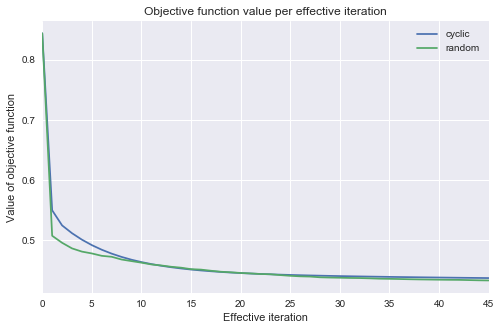

In [76]:
ax = obj_values[::X_train.shape[1]].reset_index(drop=True).plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

**TODO** do code (and of course text) for the last bullet.

# Exercise Two

"a) Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables. Hint: There are a number of functions in numpy that you can use to generate data. One example is the numpy.random.normal() func- tion; numpy.random.uniform() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes."

In [141]:
d = pd.DataFrame(np.vstack([np.random.normal(mean, size=(20,50)) for mean in [0,0.5,1]]))
d.insert(0, 'Class', np.repeat(['A','B','C'], 20))
d[:1]

,Class,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,A,0.688686,-1.097042,-1.061391,0.38873,1.081218,0.109288,-0.809478,0.704436,-0.574833,...,2.657824,-0.904406,-0.110704,1.493636,-0.304674,-0.620203,1.154927,-2.031034,-2.612273,0.604191


"b) Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors."

**TODO** How to "plot the first two principal component score vectors"? We can't plot actual vectors (i.e., lines and arrow heads) on the actual data, since the data is 50-D. Are we just doing a scatter plot? If yes, what is this showing us? Or, perhaps the seaborn plot below is actually what's being asked for, since the text above says to use a different color?

**TODO** Make sure I figure out how to generate a PDF w/ color. Or, I can update the plot to use different symbols for each class?

In [161]:
d_train_values = d.values[:, 1:51]

pca = PCA(2, svd_solver='randomized')
pca.fit(d_train_values)
values_PCA = pca.transform(d_train_values)

In [162]:
pca.components_.shape, values_PCA.shape

((2, 50), (60, 2))

In [163]:
pca.components_[0], pca.components_[1]

(array([ 0.06497839,  0.20085549,  0.17095427,  0.1684064 ,  0.07370655,
         0.10989995,  0.12046222,  0.17797694,  0.12030776,  0.09229534,
         0.11334795,  0.07370927,  0.05797845,  0.16529291,  0.0477616 ,
         0.094481  ,  0.2453061 ,  0.14830918,  0.19091553,  0.12049629,
         0.14781117,  0.19299484,  0.11280105,  0.12136043,  0.01450273,
         0.10783236,  0.04286043,  0.12067061,  0.10769289,  0.17536266,
         0.14745183,  0.17839645,  0.04589658,  0.22927469,  0.17516066,
         0.09713744,  0.13816445,  0.14785754,  0.07196629,  0.19242861,
         0.15491609,  0.15976007,  0.17019382,  0.03379855,  0.08381655,
         0.20541278,  0.17080885,  0.17265162,  0.15268417,  0.134352  ]),
 array([-0.00174002, -0.23503829, -0.07026833,  0.21368129,  0.05519519,
        -0.08395479, -0.22662309, -0.01629438,  0.10668075, -0.37839209,
         0.0518194 , -0.15298207, -0.02680685, -0.06497462, -0.11375167,
        -0.05456428, -0.16320307, -0.10406855, -0

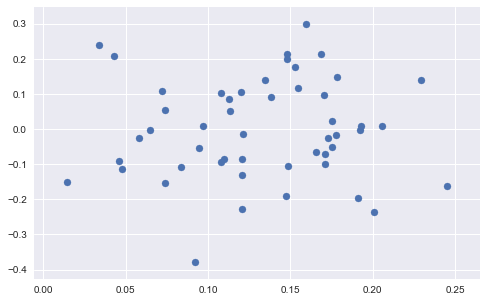

In [164]:
plt.scatter(pca.components_[0], pca.components_[1])

In [165]:
# add PCA values to the dataframe
d['PCA1'] = values_PCA[:, 0]
d['PCA2'] = values_PCA[:, 1]

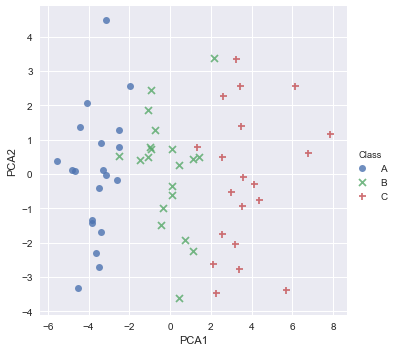

In [166]:
sns.lmplot("PCA1", "PCA2", hue="Class", markers=["o","x","+"], data=d, fit_reg=False)

"c) Perform K-means clustering of the observations with K = 3. How well do the clusters that you obtained in K-means clustering compare to the true class labels? Hint: You can use the value counts() function in the pandas package in Python to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: K-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same."

In [184]:
k = KMeans(n_clusters=3, random_state=0)
k.fit(d_train_values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [185]:
y_kmeans = k.predict(d_train_values)
y_kmeans

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [186]:
pd.Series(y_kmeans).value_counts()

2    22
0    20
1    18
dtype: int64

In [187]:
# add k=3 cluster predicted values to the dataframe
d['K3Cluster'] = y_kmeans

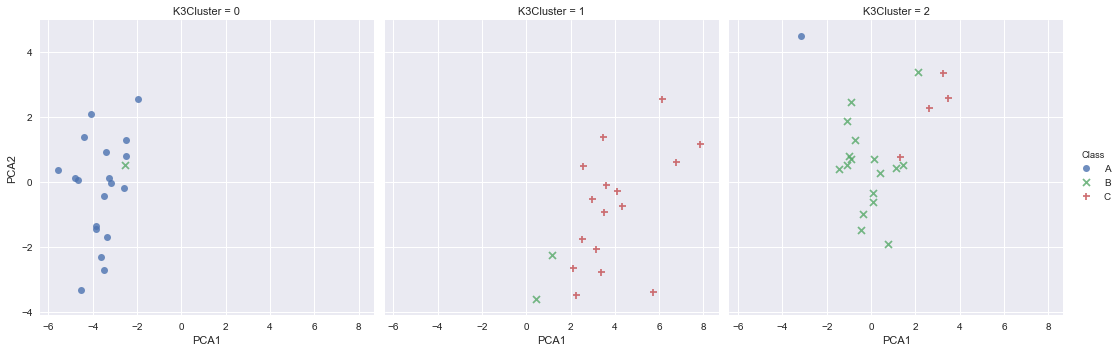

In [188]:
sns.lmplot("PCA1", "PCA2", hue="Class", col="K3Cluster", markers=["o","x","+"], data=d, fit_reg=False)

"d) Perform K-means clustering with K = 2. Describe your results."

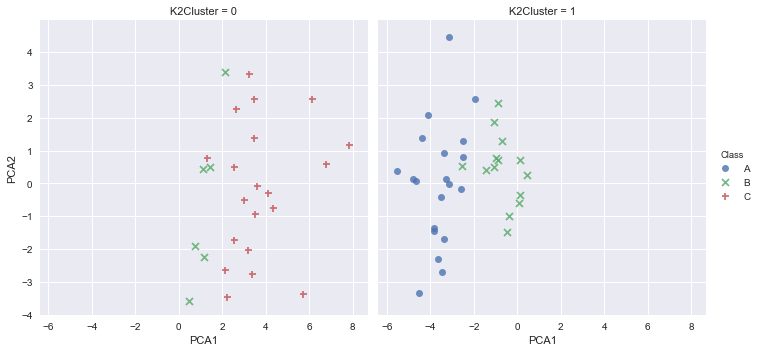

In [195]:
k = KMeans(n_clusters=2, random_state=0)
k.fit(d_train_values)
y_kmeans = k.predict(d_train_values)
d['K2Cluster'] = y_kmeans
sns.lmplot("PCA1", "PCA2", hue="Class", col="K2Cluster", markers=["o","x","+"], data=d, fit_reg=False)

"e) Now perform K-means clustering with K = 4, and describe your results."

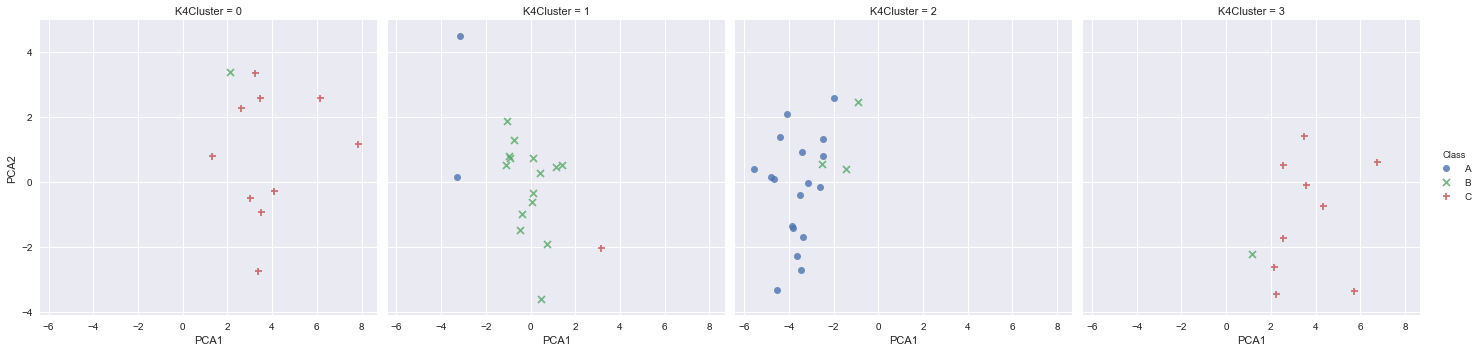

In [194]:
# this is mostly copy/paste from the previous question, but I won't worry about
# defining a function in this case, to reduce duplication
k = KMeans(n_clusters=4, random_state=0)
k.fit(d_train_values)
y_kmeans = k.predict(d_train_values)
d['K4Cluster'] = y_kmeans
sns.lmplot("PCA1", "PCA2", hue="Class", col="K4Cluster", markers=["o","x","+"], data=d, fit_reg=False)

"f) Now perform K-means clustering with K = 3 on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results."

"g) Use the StandardScaler function in sklearn.preprocessing to scale each variable to have standard deviation one. Then perform K-means clustering with K = 3 on the scaled data. How do these results compare to those obtained in (b)? Explain."

# Exercise Three